In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd

In [2]:
# Functions for sampling and finding kin
import sampling_and_kin_functions as skf

In [3]:
# Example data
parents = pd.read_csv("bearded_seal_parents.csv")

In [4]:
print(parents)

       individual  parent1  parent2  age sex  sampling_time        x         y
0           12104     7912    11179   25   F             40  3.80570  0.323896
1           12191     8176     9963   25   F             40  2.27805  2.451270
2           12763     6487    12311   24   F             40  1.08258  6.313970
3           12892     9385     1705   24   F             40  5.54065  5.391030
4           14253     9355    12394   22   F             40  7.91607  7.354790
...           ...      ...      ...  ...  ..            ...      ...       ...
13453       40034    33079    37112    1   M             60  7.47074  7.812200
13454       40050    32399    38461    1   M             60  2.13424  9.004650
13455       40057    38006    38521    1   M             60  4.28792  4.508120
13456       40063    35863    33161    1   M             60  1.85775  7.802910
13457       40066    33679    34459    1   M             60  9.65401  7.412540

[13458 rows x 8 columns]


In [5]:
# Add birth year to the data frame
# Because individuals are 1 in the year they are born, add 1
parents["birth_year"] = parents["sampling_time"] - parents["age"] + 1

In [6]:
parents.head()

,individual,parent1,parent2,age,sex,sampling_time,x,y,birth_year
0,12104,7912,11179,25,F,40,3.80570,0.323896,16
1,12191,8176,9963,25,F,40,2.27805,2.451270,16
2,12763,6487,12311,24,F,40,1.08258,6.313970,17
3,12892,9385,1705,24,F,40,5.54065,5.391030,17
4,14253,9355,12394,22,F,40,7.91607,7.354790,19


In [7]:
# Define sampling intensity grid with one side [bias] times as likely to be sampled as the other
sampling_intensity =  np.repeat([np.linspace(1, 10, 10)], 10, axis = 0)

# Sample according to the grid and return realized sampling size and sampled individuals
ss, sample_rows = skf.sample_grid(parents, sampling_intensity, 2000, 10, 10)
sample_parents = parents.iloc[sample_rows]

# Find individuals in the sample that have a child in the sample
ind_in_p1 = np.isin(sample_parents.loc[:,'individual'].values, sample_parents.loc[:,'parent1'])
ind_in_p2 = np.isin(sample_parents.loc[:,'individual'].values, sample_parents.loc[:,'parent2'])

# Mothers and Fathers
mothers = sample_parents[ind_in_p1]
fathers = sample_parents[ind_in_p2]
mother_list = mothers.loc[:,'individual'].values
father_list = fathers.loc[:,'individual'].values

# Find the parents of children in the sample and how many children in the sample they have (the parents don't need to be in the sample)
# Mothers are parent1 and fathers are parent2
all_mothers, all_mother_counts = np.unique(sample_parents.loc[:,'parent1'].values, return_counts = True)
all_fathers, all_father_counts = np.unique(sample_parents.loc[:,'parent2'].values, return_counts = True)

# Find parents with multiple children in the sample (parents of siblings)
maternal_sib_parents = all_mothers[all_mother_counts > 1]
paternal_sib_parents = all_fathers[all_father_counts > 1]

# Record POPs and half-sibling pairs
# POPs are [parent, offspring], sibs are [sib1, sib2] where sib1 is the sibling with a lower id number (which might mean younger but I'd need to check)
maternal_pops = skf.find_POPs_or_sibs(mother_list, sample_parents, "PO")
paternal_pops = skf.find_POPs_or_sibs(father_list, sample_parents, "PO")
maternal_sibs = skf.find_POPs_or_sibs(maternal_sib_parents, sample_parents, "HS")
paternal_sibs = skf.find_POPs_or_sibs(paternal_sib_parents, sample_parents, "HS")

# Full sibling pairs appear in both maternal and paternal arrays
if np.any([x in paternal_sibs for x in maternal_sibs]):
    full_sibs = maternal_sibs[np.where([x in paternal_sibs for x in maternal_sibs])[0][0]]
else:
    full_sibs = []

In [8]:
# Initialize empty dictionaries to keep track of counts
parent_counts = {}
sibling_counts = {}

# For each parent birth year b1, parent capture year y1, offspring birth year b2, and parent sex g
# Count the number of parent offspring pairs
pairs = np.concatenate([maternal_pops, paternal_pops])
sample_array = sample_parents
# pairs: An array of tuples of individual ids
# sample_array: Array containing information about each individual
for pair in pairs:
    index1 = np.where(sample_array.loc[:,'individual'] == pair[0])
    index2 = np.where(sample_array.loc[:,'individual'] == pair[1])
    row1 = sample_array.iloc[index1]
    row2 = sample_array.iloc[index2]
    b1 = row1['birth_year'].values[0]
    b2 = row2['birth_year'].values[0]
    y1 = row1['sampling_time'].values[0]
    g =  row1['sex'].values[0]
    parent_counts[(b1, y1, b2, g)] = parent_counts.get((b1, y1, b2, g), 0) + 1

# For each older sibling birth year b1, younger sibling birth year b2, and parent sex g,
# count the number of sibling pairs
pairs = maternal_sibs
# pairs: An array of tuples of individual ids
for pair in pairs:
    index1 = np.where(sample_array.loc[:,'individual'] == pair[0])
    index2 = np.where(sample_array.loc[:,'individual'] == pair[1])
    row1 = sample_array.iloc[index1]
    row2 = sample_array.iloc[index2]
    sib1_b = row1['birth_year'].values[0]
    sib2_b = row2['birth_year'].values[0]
    b1, b2 = sorted([sib1_b, sib2_b])
    g = 'F'
    sibling_counts[(b1, b2, g)] = sibling_counts.get((b1, b2, g), 0) + 1
pairs = paternal_sibs
# pairs: An array of tuples of individual ids
for pair in pairs:
    index1 = np.where(sample_array.loc[:,'individual'] == pair[0])
    index2 = np.where(sample_array.loc[:,'individual'] == pair[1])
    row1 = sample_array.iloc[index1]
    row2 = sample_array.iloc[index2]
    sib1_b = row1['birth_year'].values[0]
    sib2_b = row2['birth_year'].values[0]
    b1, b2 = sorted([sib1_b, sib2_b])
    g = 'M'
    sibling_counts[(b1, b2, g)] = sibling_counts.get((b1, b2, g), 0) + 1

print(parent_counts)
print(sibling_counts)


{(33, 50, 49, 'F'): 1, (33, 50, 44, 'F'): 1, (25, 46, 45, 'F'): 1, (40, 49, 48, 'F'): 1, (32, 45, 43, 'F'): 1, (32, 45, 42, 'F'): 1, (38, 60, 54, 'F'): 1, (38, 60, 48, 'F'): 1, (33, 43, 42, 'F'): 3, (39, 57, 53, 'F'): 1, (39, 57, 56, 'F'): 1, (39, 57, 43, 'F'): 1, (39, 57, 52, 'F'): 1, (39, 57, 51, 'F'): 1, (39, 57, 50, 'F'): 1, (39, 52, 49, 'F'): 1, (39, 52, 44, 'F'): 1, (39, 48, 46, 'F'): 2, (27, 44, 41, 'F'): 1, (27, 44, 43, 'F'): 1, (48, 56, 55, 'F'): 2, (48, 56, 51, 'F'): 1, (33, 43, 43, 'F'): 2, (38, 46, 42, 'F'): 1, (38, 46, 43, 'F'): 1, (38, 46, 44, 'F'): 1, (42, 49, 48, 'F'): 1, (46, 54, 54, 'F'): 1, (48, 59, 54, 'F'): 1, (48, 59, 57, 'F'): 1, (34, 47, 45, 'F'): 1, (48, 57, 57, 'F'): 2, (48, 57, 55, 'F'): 2, (44, 52, 52, 'F'): 1, (44, 52, 49, 'F'): 1, (26, 42, 42, 'F'): 1, (46, 56, 53, 'F'): 1, (46, 56, 56, 'F'): 1, (46, 56, 52, 'F'): 1, (50, 54, 52, 'F'): 1, (38, 57, 54, 'F'): 1, (39, 50, 44, 'F'): 1, (39, 50, 45, 'F'): 1, (32, 44, 38, 'F'): 1, (47, 53, 50, 'F'): 1, (31, 43, 

### Counting the number of comparisons for each combination of birth and sampling years

The number of parent comparisons is $n_{b_1, y_1, b_2, g} = N_{b_1, y_1, g} \times \sum_{y, g} N_{b_2, y, g}$

$$
b_1 \in \{y_1 - 37, \dots, y_1 - 1\}\\ y_1 \in \{40, \dots, 60\}\\ b_2 \in \{b_1 + 1, \dots, y_1\} \\ g \in \{1, 2\}
$$

The number of sibling comparisons is $n_{b_1, b_2, g}' = \sum_{y, g} N_{b_1, y, g} \times \sum_{y, g} N_{b_2, y, g}$

$$
b_1 \in \{1, 2, \dots, 60\} \\ b_2 \in \{b_1, \dots, 60 \} \\ g \in \{1, 2\}
$$

In [9]:
# Number of individuals born in each year
b_grouped = sample_parents.groupby(['birth_year'])
b_counts = {key: len(value) for key, value in b_grouped.groups.items()}
print(b_counts)
# Number of individuals of each birth year, capture year, and sex
byg_grouped = sample_parents.groupby(['birth_year', 'sampling_time', 'sex'])
byg_counts = {key: len(value) for key, value in byg_grouped.groups.items()}
print(byg_counts)

{17: 1, 19: 5, 22: 2, 23: 1, 24: 5, 25: 1, 26: 5, 27: 8, 28: 5, 29: 9, 30: 18, 31: 12, 32: 27, 33: 26, 34: 26, 35: 32, 36: 24, 37: 43, 38: 53, 39: 57, 40: 86, 41: 89, 42: 97, 43: 113, 44: 87, 45: 98, 46: 86, 47: 84, 48: 106, 49: 108, 50: 80, 51: 96, 52: 73, 53: 75, 54: 84, 55: 71, 56: 60, 57: 64, 58: 45, 59: 47, 60: 41}
{(17, 41, 'M'): 1, (19, 40, 'F'): 1, (19, 41, 'F'): 1, (19, 41, 'M'): 1, (19, 42, 'F'): 1, (19, 44, 'F'): 1, (22, 41, 'M'): 1, (22, 44, 'F'): 1, (23, 44, 'M'): 1, (24, 41, 'F'): 1, (24, 42, 'M'): 1, (24, 43, 'F'): 1, (24, 47, 'M'): 1, (24, 50, 'M'): 1, (25, 46, 'F'): 1, (26, 40, 'F'): 1, (26, 42, 'F'): 1, (26, 43, 'M'): 1, (26, 44, 'F'): 1, (26, 48, 'M'): 1, (27, 40, 'F'): 2, (27, 40, 'M'): 1, (27, 44, 'F'): 2, (27, 45, 'F'): 2, (27, 47, 'M'): 1, (28, 42, 'F'): 1, (28, 42, 'M'): 1, (28, 48, 'F'): 2, (28, 54, 'M'): 1, (29, 40, 'F'): 1, (29, 42, 'F'): 1, (29, 43, 'M'): 2, (29, 44, 'F'): 1, (29, 45, 'F'): 1, (29, 45, 'M'): 2, (29, 47, 'M'): 1, (30, 40, 'F'): 2, (30, 40, 'M

In [38]:
# Number of parent offspring pair comparisons
# Initialize dictionary
parent_comparisons = {}
max_a = 37
# Loop through all parents
for b1, y1, g in byg_counts.keys():
    # Loop through all offpsring
    for b2 in b_counts.keys():
        if (y1 >= b2 and b1 < y1 <= b1 + max_a and b1 <= b2 <= b1 + max_a):
            parent_comparisons[(b1, y1, b2, g)] = byg_counts[(b1, y1, g)] * b_counts[b2]                   
print(parent_comparisons)
for b1, y1, b2, g in parent_counts.keys():
    if(parent_comparisons[(b1, y1, b2, g)] < parent_counts[(b1, y1, b2, g)]):
        print("Error, more PO pairs than possible")
        break

# Number of half-sibling pair comparisons
# Initialize dictionary
sibling_comparisons = {}
# Loop through all older siblings
for b1 in b_counts.keys():
    # Loop through all younger siblings
    for b2 in b_counts.keys():
        if b2 >= b1:
            sibling_comparisons[(b1, b2, 'F')] = b_counts[b1] * b_counts[b2] 
            sibling_comparisons[(b1, b2, 'M')] = b_counts[b1] * b_counts[b2]                  
print(sibling_comparisons)
for b1, b2, g in sibling_counts.keys():
    if(sibling_comparisons[(b1, b2, g)] < sibling_counts[(b1, b2, g)]):
        print("Error, more sibling pairs than possible")
        break

{(17, 41, 17, 'M'): 1, (17, 41, 19, 'M'): 5, (17, 41, 22, 'M'): 2, (17, 41, 23, 'M'): 1, (17, 41, 24, 'M'): 5, (17, 41, 25, 'M'): 1, (17, 41, 26, 'M'): 5, (17, 41, 27, 'M'): 8, (17, 41, 28, 'M'): 5, (17, 41, 29, 'M'): 9, (17, 41, 30, 'M'): 18, (17, 41, 31, 'M'): 12, (17, 41, 32, 'M'): 27, (17, 41, 33, 'M'): 26, (17, 41, 34, 'M'): 26, (17, 41, 35, 'M'): 32, (17, 41, 36, 'M'): 24, (17, 41, 37, 'M'): 43, (17, 41, 38, 'M'): 53, (17, 41, 39, 'M'): 57, (17, 41, 40, 'M'): 86, (17, 41, 41, 'M'): 89, (19, 40, 19, 'F'): 5, (19, 40, 22, 'F'): 2, (19, 40, 23, 'F'): 1, (19, 40, 24, 'F'): 5, (19, 40, 25, 'F'): 1, (19, 40, 26, 'F'): 5, (19, 40, 27, 'F'): 8, (19, 40, 28, 'F'): 5, (19, 40, 29, 'F'): 9, (19, 40, 30, 'F'): 18, (19, 40, 31, 'F'): 12, (19, 40, 32, 'F'): 27, (19, 40, 33, 'F'): 26, (19, 40, 34, 'F'): 26, (19, 40, 35, 'F'): 32, (19, 40, 36, 'F'): 24, (19, 40, 37, 'F'): 43, (19, 40, 38, 'F'): 53, (19, 40, 39, 'F'): 57, (19, 40, 40, 'F'): 86, (19, 41, 19, 'F'): 5, (19, 41, 22, 'F'): 2, (19, 41,

In [39]:
# Survival, fecundity, and population size

def S(a, eta1_tilde, eta2_tilde, eta3_tilde, c):
    """
    Survival function
    """
    S = np.exp(-c*((eta1_tilde*a)**eta2_tilde + (eta1_tilde*a)**(1/eta2_tilde) + eta3_tilde - (eta1_tilde*(a-1))**eta2_tilde - (eta1_tilde*(a-1))**(1/eta2_tilde)))
    #S = np.exp(-c*((eta1_tilde*a)**eta2_tilde + (eta1_tilde*a)**(1/eta2_tilde) + eta3_tilde*a))
    return(S)
def f(a, nug1_tilde, nug2_tilde):
    """
    Fecundity function
    """
    return((1 + np.exp(-nug1_tilde*(a - nug2_tilde)))**(-1))
def N(max_a, max_t, R0, eta1_tilde, eta2_tilde, eta3_tilde, nu11_tilde, nu12_tilde, c):
    """
    Number of males and females of ages 1, ..., max_a at years 1, ..., max_t
    """
    N_males = np.zeros((max_a + 1, max_t + 1))
    N_females = np.zeros((max_a + 1, max_t + 1))
    ages = np.arange(max_a + 1)
    years = np.arange(max_t + 1)
    # Set all time 0 population sizes to NA because time starts at 1
    N_males[:, 0] = None
    N_females[:, 0] = None
    # Set all age 0 population sizes to NA because age starts at 1
    N_males[0,:] = None
    N_females[0,:] = None
    # Initialize the population at time 1
    N_males[1, 1] = np.exp(R0)
    N_females[1, 1] = np.exp(R0)
    # For ages 2 to max_a, initialize as a stable age distribution
    for a in ages[2:]:
        S_amin1 = S(a - 1, eta1_tilde, eta2_tilde, eta3_tilde, c)
        N_males[a, 1] = N_males[a - 1, 1] * S_amin1
        N_females[a, 1] = N_females[a - 1, 1] * S_amin1
        #print("age: ", a, "time: 1", "Ns: ", N_males[a, 1], "   ", N_females[a, 1])
    for t in years[2:]:
        # Survival model
        for a in ages[2:]:
            S_amin1 = S(a - 1, eta1_tilde, eta2_tilde, eta3_tilde, c)
            N_males[a, t] = N_males[a - 1, t - 1] * S_amin1
            N_females[a, t] = N_females[a - 1, t - 1] * S_amin1
            #print("age: ", a, "time: ", t, "Ns: ", N_males[a, 1], "   ", N_females[a, 1])
        #print("age: ", 1, "time: ", t, "Ns: ", N_males[a, 1], "   ", N_females[a, 1])
        # Fecundity model
        n_new_offspring = np.sum([f(a, nu11_tilde, nu12_tilde) * N_females[a, t] for a in ages[2:,]])
        #print(n_new_offspring)
        N_males[1, t] = 0.5 * n_new_offspring
        N_females[1, t] = 0.5 * n_new_offspring
    return N_females, N_males

In [40]:
max_a = 37
max_t = 60
R0 = 15
eta1_tilde = np.exp(-2.904)
eta2_tilde = 1 + np.exp(0.586)
eta3_tilde = np.exp(-2.579)
c = 1.111
nu11_tilde = 1.264
nu12_tilde = 5.424
nu21_tilde = 1.868
nu22_tilde = 6.5

N_females, N_males = N(max_a, max_t, R0, eta1_tilde, eta2_tilde, eta3_tilde, nu11_tilde, nu12_tilde, c)


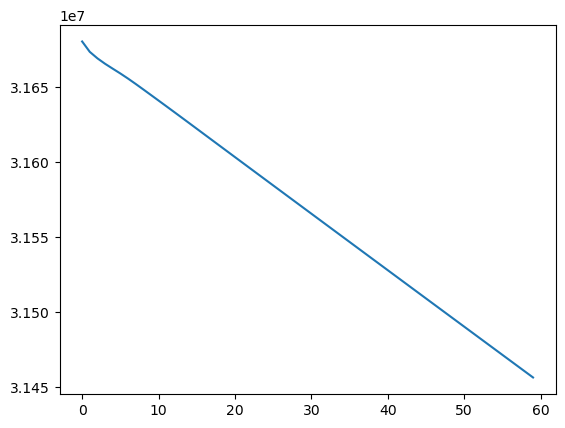

In [41]:
N_total = np.sum(N_females[1:,1:], 0) + np.sum(N_males[1:,1:], 0)
plt.plot(N_total)

### Parent-offspring probabilities

The number of offspring born to parents of sex g in year $b_2$ is:

$$
\sum_{a=2}^{37} N_{a, b_2, g}f(a,g)
$$

An individual that was born in year $b_1 < b_2$ was $b_2 - b1 + 1$ years old in year $b_2$ and on average had $f(b_2 - b_1 + 1,g)$ offspring in year $b_2$.

An individual born in year $b_1$ and sampled in year $y_1$ can be the parent of an individual born in year  $b_2$ if:

- Parent was sampled in the year of the offspring’s birth or after: $y_1 \geq b2$
- Parent was sampled within its lifetime: $b_1 < y_1 \leq b_1 + 37$
- Offspring was born before the parent died: $b_2 \leq b_1 + 37$

So, the parent-offspring pair probability for parent birth year, parent capture year, offspring birth year, and parent sex $b_1, y_1, b_2, g$ is:

$$
\frac{f(b_2 - b_1 + 1, g)}{\sum_{a=2}^{37} N_{a, b_2, g}f(a,g)}, y_1 \geq b_2, b_1 < y_1 \leq b_1 + 37, b_2 \leq b_1 + 37
$$

In [51]:
# Calculating probability of parent-offspring pair
b1 = 20 # Parent birth year
y1 = 50 # Parent capture year
b2 = 40 # Offspring birth year
g = 'F' # Parent sex
max_a = 37
def POP_probability(b1, y1, b2, g, N_females, N_males, max_a = 37):
    ages = np.arange(1,max_a + 1)
    if y1 >= b2 and b1 < y1 <= b1 + max_a and b1 <= b2 <= b1 + max_a:
        if g == 'F':
            nug1_tilde = nu11_tilde
            nug2_tilde = nu12_tilde
            N_g = N_females
        if g =='M':
            nug1_tilde = nu21_tilde
            nug2_tilde = nu22_tilde
            N_g = N_males
        # Total reproductive output in the offpsring birth year of all individuals of gender g alive at that time
        erro = np.sum([f(a, nug1_tilde, nug2_tilde) * N_g[a, b2] for a in ages[2:]])
        # Fecundity of parent in offspring birth year
        f_parent = f(b2 - b1 + 1, nug1_tilde, nug2_tilde)
        p_pop = f_parent/erro
    else:
        p_pop = 0
    return(p_pop)
print(POP_probability(b1, y1, b2, g, N_females, N_males))

1.5438035085985209e-07


### Half sibling probabilities

Older sibling birth year $b_1$, younger sibling birth year $b_2$, parent sex $g$

In year $b_1$, there are $N_a, b_1, g$ potential parents of age $a$ and sex $g$.

The probability that one of these potential parents is the parent of the older sibling is:

$$
\frac{f(a, g)}{\sum_{a'=2}^{37} N_{a', b_1, g}f(a',g)}
$$

Between the reproduction step of year $b_1$ and the reproduction step of year $b_2$, an individual goes through the survival step in years $y\in [b_1, ..., b_2 - 1]$. If the individual is of age $a$ in year $b_1$, then it is age $a^* = a + y - b_1 \in [a,...,a + b_2 - 1 - b_1]$. So the probability that the potential parent survives until the reproduction step of the year the younger sibling is born is:

$$
\prod_{y = b_1}^{b_2-1}S_{a + y - b_1}
$$

In the year of the younger siblings birth, the potential parent is age $a + b_2 - b_1$.

The probability the potential parent is the sibling of the younger sibling is:

$$
\frac{f(a + b_2 - b_1, g)}{\sum_{a'=2}^{37} N_{a', b_2, g}f(a',g)}
$$

So the half-sibling probability is:

$$
\sum_{a = 1}^{37} \frac{f(a, g)}{\sum_{a'=2}^{37} N_{a', b_1, g}f(a',g)}\prod_{y = b_1}^{b_2-1}S_{a + y - b_1}\frac{f(a + b_2 - b_1, g)}{\sum_{a'=2}^{37} N_{a', b_2, g}f(a',g)}
$$

In [52]:
# Calculating probability of half-sibling pair
b1 = 10 # Older sibling birth year
b2 = 40 # Younger sibling birth year
g = 'F' # Parent sex
max_a = 37
def HS_probability(b1, b2, g, N_females, N_males, max_a = 37):
    if b2 < b1:
        return(0)
    ages = np.arange(1,max_a + 1)
    if g == 'F':
        nug1_tilde = nu11_tilde
        nug2_tilde = nu12_tilde
        N_g = N_females
    if g =='M':
        nug1_tilde = nu21_tilde
        nug2_tilde = nu22_tilde
        N_g = N_males
    p_hs = 0
    # Sum over all possible ages
    for a in ages:
        # Total number of individuals of sex g and age a in the older sibling birth year
        N_ab1g = N_g[a, b1]
        # Total expected reproductive output of all individuals of sex g in the older sibling birth year
        erro_b1 = np.sum([f(a_prime, nug1_tilde, nug2_tilde) * N_g[a_prime, b1] for a_prime in ages[2:]])
        # Probability that an individual of age a in the older sibling birth year is the parent of the older sibling
        p_parent_older_sib = f(a, nug1_tilde, nug2_tilde)/erro_b1
        # Probability that an individual of age a in the older sibling birth year survived until the younger sibling birth year
        p_survived = np.prod([S(a + y - b1, eta1_tilde, eta2_tilde, eta3_tilde, c) for y in np.arange(b1, b2)])
        # Total expected reproductive output of all individuals of sex g in the younger sibling birth year
        erro_b2 = np.sum([f(a_prime, nug1_tilde, nug2_tilde) * N_g[a_prime, b2] for a_prime in ages[2:]])
        # Probability that an individual of age a in the older sibling birth year is the parent of the younber sibling
        p_parent_younger_sib = f(a + b2 - b1, nug1_tilde, nug2_tilde)/erro_b2
        p_hs += N_ab1g * p_parent_older_sib * p_survived * p_parent_younger_sib
    return(p_hs)
print(HS_probability(b1, b2, g, N_females, N_males, max_a))


3.406789234741717e-12


### Likelihood

Parameters to estimate: $R_0, \tilde{\eta}_1, \tilde{\eta}_2, \tilde{\eta}_3, \tilde{\nu}_{11}, \tilde{\nu}_{12}, \tilde{\nu}_{21}, \tilde{\nu}_{22}$

Observations: $m_{b_1, y_1, b_2, g}, n_{b_1, y_1, b_2, g}, m' _{b_1, b_2, g}, n' _{b_1, b_2, g}$, where $m$ is the number of parent-offspring pairs, $n$ is the number of comparisons for parent-offspring pairs, and $m^\prime$ and $n^\prime$ are the same but for sibling pairs.

Using the poisson approximation to the binomial distribution, the log-likelihood for parent-offspring pairs is then:

The negative log-likelihood for parent-offspring pairs is:

$$
\sum_{b_1}\sum_{y_1}\sum_{b_2}\sum_{g} \left(- m_{b_1, y_1, b_2, g} \log (n_{b_1, y_1, b_2, b} P_{b_1, y_1, b_2, g}) + n_{b_1, y_1, b_2, g} P_{b_1, y_1, b_2, g} \right)
$$

and the negative log-likelihood for half-sibling pairs is:

$$
\sum_{b_1}\sum_{b_2}\sum_{g} \left( - m_{b_1, b_2, g}' \log (n_{b_1, b_2, g}' P_{b_1, b_2, g}' )+ n_{b_1, b_2, g}' P_{b_1, b_2, g}'\right)
$$

The negative log likelihood for the priors on the survival parameters is:

$$
-\sum_{i=1}^3 \log\left( \mathcal{N}(\tilde{\eta}_i|\eta_i, \sigma^2_i)\right)
$$

And the negative log likelihood for the priors on the fecundity parameters is:

$$
-\sum_{i=1}^2 \sum_{g=1}^2 \log\left( \mathcal{N}(\tilde{\nu}_{g,i}|\nu_{g,i}, \tau^2_{g,i})\right)
$$

where $\mathcal{N}$ is a normal pdf.

The negative log-likelihood is then:

$$
\Lambda(R_0, \tilde{\eta}_1, \tilde{\eta}_2, \tilde{\eta}_3, \tilde{\nu}_{11}, \tilde{\nu}_{12}, \tilde{\nu}_{21}, \tilde{\nu}_{22} |\mathbf{m}, \mathbf{n}, \mathbf{m}' , \mathbf{n}' ) = \\\sum_{b_1}\sum_{y_1}\sum_{b_2}\sum_{g} \left( -m_{b_1, y_1, b_2, g} \log (n_{b_1, y_1, b_2, b} P_{b_1, y_1, b_2, g}) + n_{b_1, y_1, b_2, g} P_{b_1, y_1, b_2, g}\right) + \sum_{b_1}\sum_{b_2}\sum_{g} \left( -m_{b_1, b_2, g}' \log (n_{b_1, b_2, g}' P_{b_1, b_2, g}' )+ n_{b_1, b_2, g}' P_{b_1, b_2, g}'\right)-\\\sum_{i=1}^3 \log\left( \mathcal{N}(\tilde{\eta}_i|\eta_i, \sigma^2_i)\right)-\sum_{i=1}^2 \sum_{g=1}^2 \log\left( \mathcal{N}(\tilde{\nu}_{g,i}|\nu_{g,i}, \tau^2_{g,i})\right)
$$

In [44]:
# Define the negative log likelihood function
# Parameters to estimate: R0, eta1_tilde, eta2_tilde, eta3_tilde, nu11_tilde, nu12_tilde, nu21_tilde, nu22_tilde
# Observations: parent_counts, sibling_counts, parent_comparisons, sibling_comparisons
R0 = 15
eta1_tilde = np.exp(-2.904)
eta2_tilde = 1 + np.exp(0.586)
eta3_tilde = np.exp(-2.579)
c = 1.111
nu11_tilde = 1.264
nu12_tilde = 5.424
nu21_tilde = 1.868
nu22_tilde = 6.5
# Other quantities
max_a = 37
max_t = 60
N_females, N_males = N(max_a, max_t, R0, eta1_tilde, eta2_tilde, eta3_tilde, nu11_tilde, nu12_tilde, c)
# Prior parameters
# Means and SDs for normal priors on survival parameters
eta1, eta2, eta3 = 0.055, 2.8, 0.076
# Need to check these
sigma1, sigma2, sigma3 = np.exp(0.15), np.exp(0.25), np.exp(0.5)
# Means and SDs for normal priors on fecundity parameters
nu11, nu12, nu21, nu22 = 1.264, 5.424, 1.868, 6.5
tau11, tau12, tau21, tau22 = 0.4*nu11, 0.4*nu12, 0.4*nu21, 0.4*nu22


In [45]:
# Parent section of the negative log likelihood
PO_nll = 0
for b1, y1, b2, g in parent_comparisons.keys():
    p_pop = POP_probability(b1, y1, b2, g)
    n = parent_comparisons[(b1, y1, b2, g)]
    m = parent_counts.get((b1, y1, b2, g), 0)
    if p_pop != 0:
        PO_nll += -m*np.log(n*p_pop) + n*p_pop
print(PO_nll)
# Sibling section of the negative log likelihood
HS_nll = 0
for b1, b2, g in sibling_comparisons.keys():
    p_hs = HS_probability(b1, b2, g)
    n_prime = sibling_comparisons[(b1, b2, g)]
    m_prime = sibling_counts.get((b1, b2, g), 0)
    if p_hs != 0:
        HS_nll += -m_prime*np.log(n_prime*p_hs) + n_prime*p_hs
print(HS_nll)
# Negative log likelihood for priors on the survival parameters
survival_nll = -(stats.norm.pdf(eta1_tilde, eta1, sigma1) + stats.norm.pdf(eta2_tilde, eta2, sigma2) + stats.norm.pdf(eta3_tilde, eta3, sigma3))
# Negative log likelihood for priors on the fecundity parameters
fecundity_nll = -(stats.norm.pdf(nu11_tilde, nu11, tau11) + stats.norm.pdf(nu12_tilde, nu12, tau12) +
                   stats.norm.pdf(nu21_tilde, nu21, tau21) + stats.norm.pdf(nu22_tilde, nu22, tau22))


7234.246637744484
13533.745633497821


In [46]:
nll = PO_nll + HS_nll + survival_nll + fecundity_nll
print(nll)

20765.435950971183


In [53]:
def nll(params, survival_prior_params, fecundity_prior_params, parent_counts, sibling_counts, parent_comparisons, sibling_comparisons, c = 1.111, max_a = 37, max_t = 60):
    """
    Log likelihood function of params given parent and sibling pair counts
    """
    # Unpack the parameters
    R0, eta1_tilde, eta2_tilde, eta3_tilde, nu11_tilde, nu12_tilde, nu21_tilde, nu22_tilde = params
    eta1, eta2, eta3, sigma1, sigma2, sigma3 = survival_prior_params
    nu11, nu12, nu21, nu22, tau11, tau12, tau21, tau22 = fecundity_prior_params
    # Population size model
    N_females, N_males = N(max_a, max_t, R0, eta1_tilde, eta2_tilde, eta3_tilde, nu11_tilde, nu12_tilde, c)
    # Parent section of the negative log likelihood
    PO_nll = 0
    for b1, y1, b2, g in parent_comparisons.keys():
        p_pop = POP_probability(b1, y1, b2, g, N_females = N_females, N_males = N_males, max_a = max_a)
        n = parent_comparisons[(b1, y1, b2, g)]
        m = parent_counts.get((b1, y1, b2, g), 0)
        if p_pop != 0:
            PO_nll += -m*np.log(n*p_pop) + n*p_pop
    #print(PO_nll)
    # Sibling section of the negative log likelihood
    HS_nll = 0
    for b1, b2, g in sibling_comparisons.keys():
        p_hs = HS_probability(b1, b2, g, N_females = N_females, N_males = N_males, max_a = max_a)
        n_prime = sibling_comparisons[(b1, b2, g)]
        m_prime = sibling_counts.get((b1, b2, g), 0)
        if p_hs != 0:
            HS_nll += -m_prime*np.log(n_prime*p_hs) + n_prime*p_hs
    #print(HS_nll)
    # Negative log likelihood for priors on the survival parameters
    survival_nll = -(stats.norm.pdf(eta1_tilde, eta1, sigma1) + stats.norm.pdf(eta2_tilde, eta2, sigma2) + stats.norm.pdf(eta3_tilde, eta3, sigma3))
    # Negative log likelihood for priors on the fecundity parameters
    fecundity_nll = -(stats.norm.pdf(nu11_tilde, nu11, tau11) + stats.norm.pdf(nu12_tilde, nu12, tau12) +
                    stats.norm.pdf(nu21_tilde, nu21, tau21) + stats.norm.pdf(nu22_tilde, nu22, tau22))
    nll = PO_nll + HS_nll + survival_nll + fecundity_nll
    return(nll)
    

In [54]:
R0 = 15
eta1_tilde = np.exp(-2.904)
eta2_tilde = 1 + np.exp(0.586)
eta3_tilde = np.exp(-2.579)
nu11_tilde = 1.264
nu12_tilde = 5.424
nu21_tilde = 1.868
nu22_tilde = 6.5
# Prior parameters
# Means and SDs for normal priors on survival parameters
survival_priors = 0.055, 2.8, 0.076, np.exp(0.15), np.exp(0.25), np.exp(0.5)
# Means and SDs for normal priors on fecundity parameters
fecundity_priors = 1.264, 5.424, 1.868, 6.5, 0.4*1.264, 0.4*5.424, 0.4*1.868, 0.4*6.5
print(nll([R0, eta1_tilde, eta2_tilde, eta3_tilde, nu11_tilde, nu12_tilde, nu21_tilde, nu22_tilde], survival_priors, fecundity_priors, parent_counts, sibling_counts, parent_comparisons, sibling_comparisons))

20765.435950971183
